In [ ]:
!pip install bigframes

In [2]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

In [3]:
client = bigquery.Client()

In [6]:
query = """
SELECT * 
FROM `sapient-stacker-407917.employee_data_company_data_firmographic_data_global_769m.member_education`
LIMIT 100;
"""

query = """
SELECT * 
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE year = 2016
LIMIT 100;
"""

query_job = client.query(query)
df = pd.DataFrame([dict(row.items()) for row in query_job])
# df

In [7]:
df

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01000848,Camden,Sexual Offences,Rape,0,2016,12
1,E01000471,Brent,Sexual Offences,Rape,0,2016,6
2,E01000478,Brent,Sexual Offences,Rape,0,2016,4
3,E01000294,Barnet,Sexual Offences,Rape,0,2016,3
4,E01000927,Camden,Sexual Offences,Rape,0,2016,6
...,...,...,...,...,...,...,...
95,E01001646,Greenwich,Sexual Offences,Rape,0,2016,12
96,E01001646,Greenwich,Sexual Offences,Rape,0,2016,10
97,E01001640,Greenwich,Sexual Offences,Rape,0,2016,11
98,E01000992,Croydon,Sexual Offences,Rape,0,2016,5


In [47]:
query = """SELECT table_name
FROM `sapient-stacker-407917.employee_data_company_data_firmographic_data_global_769m.INFORMATION_SCHEMA.TABLES`;"""
query_job = client.query(query)

In [48]:
for row in query_job:
    print(row)

Row(('member_education',), {'table_name': 0})
Row(('member 1',), {'table_name': 0})


In [8]:
%%bigquery results
SELECT * FROM `bigquery-public-data.london_crime.crime_by_lsoa` #this table name was set based on the table you chose to query

Query is running:   0%|          |

Downloading:   0%|          |

In [19]:
%%bigquery results
SELECT borough, COUNT(*) as total_crimes
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE year = 2016
GROUP BY borough
ORDER BY total_crimes DESC

Query is running:   0%|          |

Downloading:   0%|          |

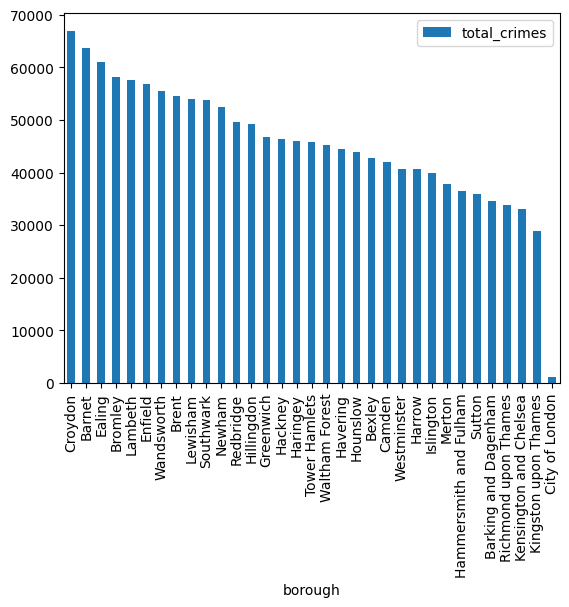

In [20]:
import matplotlib.pyplot as plt

# Visualiza los resultados
results.plot(kind='bar', x='borough', y='total_crimes')
plt.show()

In [23]:
from google.cloud import bigquery

client = bigquery.Client()

dataset_id = "{}.mi_dataset".format(client.project)
dataset_id

'sapient-stacker-407917.mi_dataset'

In [25]:
dataset = bigquery.Dataset(dataset_id)
dataset

Dataset(DatasetReference('sapient-stacker-407917', 'mi_dataset'))

In [26]:
dataset.location = "EU"

dataset = client.create_dataset(dataset, timeout=30)  # Lanza una excepción si falla.
print("Dataset creado. ID: {}".format(dataset_id))

Dataset creado. ID: sapient-stacker-407917.mi_dataset


In [27]:
%%bigquery
CREATE OR REPLACE MODEL `mi_dataset.modelo_prediccion_crimen`
OPTIONS(model_type='linear_reg', input_label_cols=['total_crimes']) AS
SELECT
  lsoa_code,
  year,
  month,
  COUNT(value) AS total_crimes
FROM
  `bigquery-public-data.london_crime.crime_by_lsoa`
GROUP BY
  lsoa_code,
  year,
  month;

Query is running:   0%|          |

""


In [30]:
%%bigquery evaluation_results
SELECT * FROM ML.EVALUATE(MODEL `mi_dataset.modelo_prediccion_crimen`);

Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
evaluation_results.to_dict()

{'mean_absolute_error': {0: 1.5944675767860788e-08},
 'mean_squared_error': {0: 2.8348915778623843e-16},
 'mean_squared_log_error': {0: 4.774336357370039e-19},
 'median_absolute_error': {0: 1.558826312475503e-08},
 'r2_score': {0: 0.9999999999999999},
 'explained_variance': {0: 1.0}}

In [40]:
%%bigquery conteo_2016_1
SELECT COUNT(*)
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE year = 2016 AND month = 1;

Query is running:   0%|          |

Downloading:   0%|          |

In [41]:
conteo_2016_1

,f0_
0,124913


In [37]:
%%bigquery prediction_results
SELECT
  lsoa_code,
  year,
  month,
  predicted_total_crimes
FROM
  ML.PREDICT(MODEL `mi_dataset.modelo_prediccion_crimen`,
    (SELECT
       lsoa_code,
       year,
       month
     FROM
       `bigquery-public-data.london_crime.crime_by_lsoa`
     WHERE
       year = 2016 AND month = 1));

Query is running:   0%|          |

Downloading:   0%|          |

In [38]:
prediction_results

,lsoa_code,year,month,predicted_total_crimes
0,E01001331,2016,1,28.0
1,E01000619,2016,1,25.0
2,E01000257,2016,1,28.0
3,E01000927,2016,1,27.0
4,E01000570,2016,1,30.0
...,...,...,...,...
124908,E01000369,2016,1,24.0
124909,E01000364,2016,1,24.0
124910,E01001464,2016,1,24.0
124911,E01033592,2016,1,24.0


In [10]:
# @title Example 2: Query a table with BigQuery DataFrames
# With BigQuery DataFrames, you can use many familiar Pandas methods, but the
# processing happens BigQuery rather than the runtime, allowing you to work with larger
# DataFrames that would otherwise not fit in the runtime memory.
# Learn more here: https://cloud.google.com/python/docs/reference/bigframes/latest

import bigframes.pandas as bf

# bf.options.bigquery.location = "EU" #this variable is set based on the dataset you chose to query
# bf.options.bigquery.project = "sapient-stacker-407917" #this variable is set based on the dataset you chose to query

In [11]:
df = bf.read_gbq("bigquery-public-data.london_crime.crime_by_lsoa") #this variable is set based on the dataset you chose to query

In [12]:
# BigFrames can work with tables that are too large to fit in the notebook memory.
# Look at the first 20 rows.
df.head(20)

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01000127,Barnet,Theft and Handling,Theft From Shops,0,2013,12
1,E01003287,Lewisham,Drugs,Possession Of Drugs,1,2011,10
2,E01001244,Ealing,Violence Against the Person,Assault with Injury,0,2010,7
3,E01003768,Redbridge,Violence Against the Person,Offensive Weapon,1,2014,1
4,E01003946,Southwark,Other Notifiable Offences,Other Notifiable,1,2010,7
5,E01000788,Bromley,Fraud or Forgery,Counted per Victim,0,2008,5
6,E01000879,Camden,Other Notifiable Offences,Other Notifiable,0,2012,6
7,E01002099,Haringey,Sexual Offences,Other Sexual,0,2014,8
8,E01002355,Havering,Theft and Handling,Theft From Motor Vehicle,0,2014,10
9,E01003137,Lambeth,Theft and Handling,Theft/Taking Of Motor Vehicle,1,2014,11


In [14]:
df.tail(5)

,lsoa_code,borough,major_category,minor_category,value,year,month
13490599,E01003980,Southwark,Violence Against the Person,Murder,0,2012,12
13490600,E01000102,Barking and Dagenham,Other Notifiable Offences,Other Notifiable,0,2016,10
13490601,E01001206,Ealing,Drugs,Drug Trafficking,1,2012,8
13490602,E01004086,Sutton,Theft and Handling,Theft From Shops,0,2012,2
13490603,E01004246,Tower Hamlets,Theft and Handling,Other Theft,3,2008,4


In [13]:
df

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01000127,Barnet,Theft and Handling,Theft From Shops,0,2013,12
1,E01003287,Lewisham,Drugs,Possession Of Drugs,1,2011,10
2,E01001244,Ealing,Violence Against the Person,Assault with Injury,0,2010,7
3,E01003768,Redbridge,Violence Against the Person,Offensive Weapon,1,2014,1
4,E01003946,Southwark,Other Notifiable Offences,Other Notifiable,1,2010,7
5,E01000788,Bromley,Fraud or Forgery,Counted per Victim,0,2008,5
6,E01000879,Camden,Other Notifiable Offences,Other Notifiable,0,2012,6
7,E01002099,Haringey,Sexual Offences,Other Sexual,0,2014,8
8,E01002355,Havering,Theft and Handling,Theft From Motor Vehicle,0,2014,10
9,E01003137,Lambeth,Theft and Handling,Theft/Taking Of Motor Vehicle,1,2014,11
